# Filter-to-Waste Recycle Injection
## Pump, System Curve and Control Valve Sizing
This Jupyter Notebook walks through a python script that calculates the FTW recycle injection control valve 
position based on head conditions between high and low demand modes.
Major and minor losses are taken into account from the FTW storage tank
to the high water level at the DAF.

Uses Water package developed by Ryan Haseman

In [1]:
# importing necessary python libraries
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
from Water import *

### Filter-to-Waste Storage Tank

In [2]:
# define system info and create tank object
# water system info
system_name = "Rosario"
station_name = "Water Treatment Plant"
tank_data = {          
    'name' : 'ftw_storage',
    'diameter' : 11.75,
    'height' : 13.08,
    'freeboard' : 1.5,
    'deadstorage' : 1.5,
    'elevation' : 340
}
# create storage tank 
storage = Tank(**tank_data)   # FTW storage tank

In [3]:
# print tank information
print(storage.getInfo())


            ftw_storage 

            Base Elevation:------------- 340 ft
            Orientation:---------------- vertical
            Tank Height:---------------- 13.08 ft
            Tank Diameter:-------------- 11.75 ft
            Tank cross-sectional area:-- 108.4 ft^2
            Total volume:--------------- 10609.7 gal
            Effective volume:----------- 8176.3 gal
            


### Flow parameters 

In [4]:
# flow parameters
Q_hi = 23      # gpm
Q_low = 14     # gpm
Q_vec = np.linspace(Q_low, Q_hi, num=((Q_hi - Q_low)+1))  # <Q_low, ..., Q_hi>

# Final pumping height
outlet_height = 12      # ft  DAF water level 

## Pipe Section Definitions
Suction and Discharge fittings and pipe sections are defined in order to calculate the Total Dynamic Head for the system.

In [5]:
################ SUCTION SIDE PIPE AND FITTINGS ################
'''
consists of: 
- storage tank to pump
'''
# pipe parameters 
s2p_size = 2  # in. (nom)
s2p_len = 6   # ft 
s2p = Pipe(s2p_len, s2p_size, 'PVC', sch=80) # pipe section object

# adding fittings to pipe section
s2p.fitting('elbow_90', 'standard_glued', 3)
s2p.fitting('valve', 'ball',2)

In [6]:
################# DISCHARGE SIDE PIPE AND FITTINGS ####################
'''
consists of: 
- pump to reducer
- reducer to injection point
- injection point to DAF
- 2" bypass 
'''
### pump to reducer ###
# pipe parameters
p2r_size = 1   # in. (nom)
p2r_len = 2    # ft
p2r = Pipe(p2r_len, p2r_size, 'PVC',sch=80)   # pipe object

# fittings for pump to reducer section
p2r.fitting('elbow_90', 'standard_glued', 1)
p2r.fitting('tee_through', 'standard_glued', 1)
p2r.fitting('reducer', 'standard_glued', 1, 0.8)

### reducer to injection point ###
# pipe parameters
r2ip_size = 1.25   # in. (nom)
r2ip_length = 50   # ft
r2ip = Pipe(r2ip_length, r2ip_size, 'PVC', sch=40)     # pipe object

# fittings for reducer to injection point section
# (assuming control valve wide open)
r2ip.fitting('elbow_90', 'standard_glued', 2)
r2ip.fitting('tee_branch', 'standard_glued')
r2ip.fitting('valve', 'ball', 2)
r2ip.fitting('valve', 'swing_check')

### injection point to DAF ###
# pipe paramters
ip2DAF_size = 8        # in. (nom)
ip2DAF_length = 180    # ft
ip2DAF = Pipe(ip2DAF_length, ip2DAF_size, 'PVC', sch=80)    # pipe object

# fittings for injection point to DAF
ip2DAF.fitting('elbow_90', 'standard_glued', 20)
ip2DAF.fitting('tee_branch', 'standard_glued',2)
ip2DAF.fitting('valve', 'butterfly', 2)
ip2DAF.fitting('valve', 'swing_check')
ip2DAF.fitting('static_mixer', 'standard_threaded', 1, 2)
ip2DAF.fitting('flow_meter', 'standard_threaded', 1, 4)

#### 2 inch bypass in feed line ###
# pipe parameters
bypass_size = 2     # in. (nom)
bypass_length = 5   # ft
bypass = Pipe(bypass_length, bypass_size, kind='PVC', sch=80)    # pipe object

# fittings in bypass
bypass.fitting('valve', 'gate')
bypass.fitting('tee_branch', 'standard_glued', 2)


## Major and Minor Losses Calculations
Losses are calculated using flow vector (Q_vec)

In [7]:
# Calculating losses for pipes and fittings 
pipes = [s2p, p2r, r2ip, ip2DAF, bypass]  # list of pipe sections previously created

losses = []
# calculating losses for all pipes and fittings
for each_pipe in pipes:
    q_list = []
    for each_flow in Q_vec:
        q_list.append(each_pipe.get_losses(each_flow))
    losses.append(q_list)

# identify suction side losses
suc_losses = losses[0]
# sum all sections for discharge side losses
dis_losses = sum(np.array(losses[1:]))
Q_vec = list(Q_vec)

# report findings
#print(tools.report_losses(suc_losses, Q_vec, 'suction losses'))
#print(tools.report_losses(dis_losses, Q_vec, 'discharge losses'))

In [8]:
type(list(Q_vec))

list

## Pumping Head Calculations
Total Dynamic Head Calculations for the system

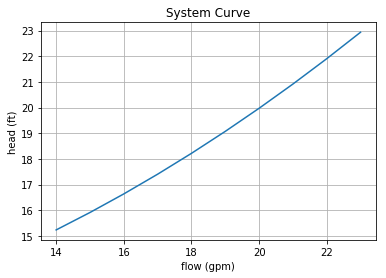

In [9]:
########### Pumping Head Calculations #############

# suction head
suc_head = [x - storage.deadstorage for x in suc_losses]
# discharge head
dis_head = [x + outlet_height for x in dis_losses] 
# total dynamic head condition for each flow in Q_vec
tdh = [sum(x) for x in zip(dis_head, suc_head)]

# Output result as System Curve
plt.plot(Q_vec, tdh)
plt.title('System Curve')
plt.xlabel('flow (gpm)')
plt.ylabel('head (ft)')
plt.grid()

## Specify Pump for FTW Injection
Create pump object and get curve data

In [10]:
########## Pump Specification ############

# create injection pump
inj_pump = Pump()
inj_pump.available_pumps()

(1, 'Goulds', '3657 1.5x2 -6: 3SS', 110, 105)
(2, 'Goulds', '3642-1x1_25-3500', 20, 30)
(3, 'Grundfos', 'CM10-2-A-S-G-V-AQQV', 60, 110)
(4, 'Goulds', '25GS50', 25, 520)
(5, 'Goulds', '35GS50', 35, 420)
(6, 'Goulds', '75GS100CB', 75, 395)
(7, 'Goulds', '85GS100', 80, 390)
(8, 'Grundfos', 'CMBE 5-62', 20, 197)
(9, 'Goulds', '85GS75', 80, 305)
(10, 'Grundfos', '85S100-9', 80, 375)


[(2, 'Goulds', '3642-1x1_25-3500', 30, 0, 20, 40, 21, 30, 45.0, 3500, '3.1875', '[0, 5, 10, 15, 20, 25, 30]', '[40, 38, 36, 34, 30, 27, 21]', '[0.0, 30.0, 37.0, 42.0, 45.0, 43.0, 40.0]')]
Pump loaded from database


TypeError: 'Figure' object is not callable

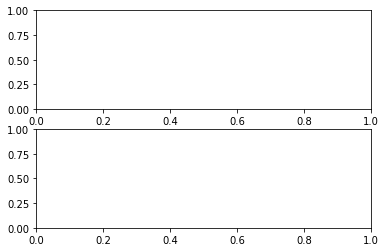

In [11]:
# load pump data for Goulds 3642
inj_pump.load_pump('Goulds', '3642-1x1_25-3500')
inj_pump.plot_curve(target_flow=Q_vec, tdh=tdh)

## Find Cv value required for control valve 

In [ ]:
# find head on pump curve for desired flows
head = [inj_pump.find_head(x) for x in Q_vec]

# find difference between pump curve head and system curve
delta_p = [x-y for x,y in zip(head, tdh)]

# calculate Cv value required to meet pump curve
Cv = [q / np.sqrt(dp) for q, dp in zip(Q_vec, delta_p)]

# create new system curve with added Cv from control valve
tdh_with_valve = [sum(x) for x in zip(tdh, delta_p)]

## Valve data selected from manufactures chart for 1-1/4" valve with 30 deg v-port

<img src="v_port.png">

In [ ]:
# data from selected V8 series valve with 30 degree port mfg chart
Cv_valve = [0.0, 0.2, 0.4, 1.1, 2.0, 3.7, 5.5, 8.0, 10.0, 13.0, 15.0]
valve_pos = [0, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]   # percent open

# plot valve curve
plt.plot(valve_pos, Cv_valve)
plt.title("V-Series Control Ball Valve w/ 30deg port")
plt.xlabel("% Open")
plt.ylabel("Cv value")
plt.grid()

## Calculate Control Valve Position by interpolating data 

In [ ]:
control_pos = [np.interp(x, Cv_valve, valve_pos) for x in Cv]
pos_str = ["{:.1f}".format(x) + " %" for x in control_pos]  # string output for graphing

## Plot adjusted system curve with pump curve and original system curve

In [ ]:
# create plots for system curve, pump curve, adjusted system curve
# (the rest of this code is just for plotting a graph of the results)
plt.figure(figsize=(12,4))
# pump curve
plt.plot(inj_pump.flow, inj_pump.head)
# system curve (no valve)
plt.plot(Q_vec, tdh)
# adujsted system curve (with valve)
plt.plot(Q_vec, tdh_with_valve, lw=3, color='red')
plt.fill_between(Q_vec, tdh_with_valve, tdh, facecolor="palegreen")
for i, txt in enumerate(pos_str):
    plt.annotate(txt, xy=(Q_vec[i], tdh_with_valve[i]), fontsize=10)
plt.title("Pump Curve and System Curve using Control Valve")
plt.xlabel("Flow (gpm)")
plt.ylabel("Head (ft)")
plt.xlim((12,25))
plt.text(Q_vec[3], tdh[-1] + 20, "(% Open)")
plt.grid()
plt.legend(['pump curve','sys curve (no valve)', 'sys curve (with valve)'])
